In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [21]:
train = pd.read_csv('data/train.csv',parse_dates='datetime',index_col='datetime')
test = pd.read_csv('data/test.csv',parse_dates='datetime',index_col='datetime')
test[:10]


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012


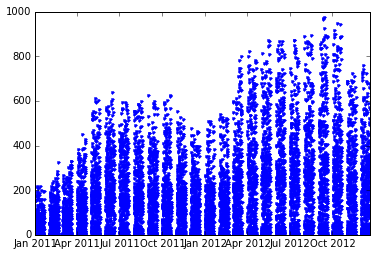

In [17]:
plot(train.index,train['count'],'.')

In [64]:
train['hour'] = train.index.hour
train['month'] = train.index.month
train['year'] = train.index.year
train[:3]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,0,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2,1,2011


In [46]:
from sklearn import svm
from sklearn import cross_validation

In [72]:
features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','month','year','casual','registered']
features = ['casual','registered']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
train[features], train['count'], test_size=0.4)
clf = svm.SVC()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)

In [73]:
print predictions[:10]
print y_test[:10]
err = 0
for i, pred in enumerate(predictions):
    err += (np.log1p(pred)-np.log1p(y_test[i]))**2
J = (err/len(predictions))**.5
J

[123  27   8   6   7  75 205 180 130 205]
[124  27   9   6   7  76 256 179 131 517]


0.41562488509273793